#Bibliotecas

In [ ]:
!pip install yfinance


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# importar as bibliotecas
import warnings
warnings.filterwarnings('ignore')


# GradienteBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd


import pickle
import joblib

#Upload -dataframe dados

In [ ]:
#fonte dos índices e cotações:   https://finance.yahoo.com/
indice = "BZ=F"   # Brent Crude Oil Last Day Financ (BZ=F)
inicio = "2007-07-30" #Define a data de ínicio para importação dos dados
#Coleta dados históricos do índice de referência até a data corrente
dados_acao = yf.download(indice, inicio)
#Quando a biblioteca é chamada sem uma data final, carrega as cotações até a data corrente
df_cotacoes =pd.DataFrame(dados_acao)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
dados = df_cotacoes.copy()

In [ ]:
dados.shape

(4172, 6)

In [ ]:
dados.drop('Adj Close', axis=1, inplace=True)
dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4172 entries, 2007-07-30 to 2024-05-17
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    4172 non-null   float64
 1   High    4172 non-null   float64
 2   Low     4172 non-null   float64
 3   Close   4172 non-null   float64
 4   Volume  4172 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 195.6 KB


In [ ]:
dados = dados.reset_index()
dados.isnull().sum()
dados.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
dtype: object

In [ ]:
dados.tail()  #última data 2024-05-2014

,Date,Open,High,Low,Close,Volume
4167,2024-05-13,82.699997,83.830002,82.260002,83.360001,29242
4168,2024-05-14,83.500000,83.620003,82.099998,82.379997,33169
4169,2024-05-15,82.769997,83.070000,81.059998,82.750000,41744
4170,2024-05-16,82.930000,83.779999,82.309998,83.269997,27576
4171,2024-05-17,83.440002,84.040001,83.089996,83.980003,27576


In [ ]:
dados['Date'] = pd.to_datetime(dados['Date'], dayfirst=True)
dados = dados.set_index('Date')

In [ ]:
dados.describe()

,Open,High,Low,Close,Volume
count,4172.000000,4172.000000,4172.000000,4172.000000,4172.000000
mean,78.695000,79.659192,77.676254,78.697919,17493.302253
std,24.748244,24.866942,24.618045,24.766609,16184.802106
min,19.559999,21.270000,16.000000,19.330000,0.000000
25%,59.070000,60.027499,58.222500,59.012501,1131.000000
50%,76.730003,77.639999,75.674999,76.844997,16646.000000
75%,101.745003,102.967499,100.367500,101.742498,30044.250000
max,146.080002,147.429993,144.270004,146.080002,87185.000000


#Upload com url

In [ ]:
dados_site = pd.read_html('http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view[2]')

dados_url = dados_site[2]

#dados = dados.reset_index()

dados_url.columns = ['Data','Preco_Petroleo_Brent_FOB']

dados_url.set_index('Data')

dados_url = dados_url.iloc[1:]

dados_url.fillna(method='ffill', inplace=True)

dados_url['Preco_Petroleo_Brent_FOB'] = dados_url['Preco_Petroleo_Brent_FOB'].astype('float')/100

dados_url['Data'] = pd.to_datetime(dados_url['Data'], dayfirst=True)

dados_url = dados_url.set_index('Data').sort_index(ascending=True)

dados_url = dados_url.reset_index()

In [ ]:
dados_url.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11169 entries, 0 to 11168
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Data                      11169 non-null  datetime64[ns]
 1   Preco_Petroleo_Brent_FOB  11169 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 174.6 KB


#Criando o dataframe df_gb

In [ ]:
df_complementar = dados.reset_index()[['Date', 'Close']]
df_complementar.columns = ['Data','Preco_Petroleo_Brent_FOB']
df_complementar['Data'] = pd.to_datetime(df_complementar['Data'], dayfirst=True)
df_complementar.tail()

,Data,Preco_Petroleo_Brent_FOB
4167,2024-05-13,83.360001
4168,2024-05-14,82.379997
4169,2024-05-15,82.750000
4170,2024-05-16,83.269997
4171,2024-05-17,83.980003


In [ ]:
df_gb = dados_url[['Data','Preco_Petroleo_Brent_FOB']].copy()
selecao = (df_gb['Data'] >= '2000-01-01')
df_gb = df_gb[selecao]
df_gb = df_gb.set_index('Data')
df_gb = df_gb.sort_index(ascending=True)
df_gb = df_gb.reset_index()
df_gb.tail()

,Data,Preco_Petroleo_Brent_FOB
7964,2024-05-07,82.69
7965,2024-05-08,82.44
7966,2024-05-09,83.27
7967,2024-05-10,83.39
7968,2024-05-13,83.18


In [ ]:
ultimo_registro = df_gb['Data'].max()
ultimo_registro

Timestamp('2024-05-13 00:00:00')

In [ ]:
nova_linha = df_complementar[df_complementar['Data'] > ultimo_registro]
nova_linha

,Data,Preco_Petroleo_Brent_FOB
4168,2024-05-14,82.379997
4169,2024-05-15,82.750000
4170,2024-05-16,83.269997
4171,2024-05-17,83.980003


In [ ]:
if not nova_linha.empty:
  df_gb = pd.concat([df_gb, nova_linha], ignore_index=True)
else:
  df_gb = df_gb


In [ ]:
df_gb['Data'].max()

Timestamp('2024-05-17 00:00:00')

In [ ]:
df_gb['ano'] = df_gb['Data'].dt.year
df_gb['mes'] = df_gb['Data'].dt.month

In [ ]:
groupby_ano =df_gb[['ano','Preco_Petroleo_Brent_FOB']].groupby(['ano']).mean('Preco_Petroleo_Brent_FOB')
groupby_ano.to_csv('agrupado.csv', index=True)

In [ ]:
df_gb['Diferenca(%)'] = df_gb['Preco_Petroleo_Brent_FOB'].dropna().pct_change()*100
df_gb['Afastamento_da_media'] = df_gb['Preco_Petroleo_Brent_FOB'] - df_gb['Preco_Petroleo_Brent_FOB'].mean()

In [ ]:
df_gb.to_csv('df_completo.csv', index=False)

In [ ]:
df_gb[['Data','Preco_Petroleo_Brent_FOB']].to_csv('ipea.csv', index=False)

In [ ]:
df_gb.head()

,Data,Preco_Petroleo_Brent_FOB,ano,mes,Diferenca(%),Afastamento_da_media
0,2000-01-04,23.95,2000,1,NaN,-43.11375
1,2000-01-05,23.72,2000,1,-0.960334,-43.34375
2,2000-01-06,23.55,2000,1,-0.716695,-43.51375
3,2000-01-07,23.35,2000,1,-0.849257,-43.71375
4,2000-01-10,22.77,2000,1,-2.483940,-44.29375


In [ ]:
menor = df_gb['Preco_Petroleo_Brent_FOB'].min()
min_data = df_gb[['Data','Preco_Petroleo_Brent_FOB']].loc[df_gb['Preco_Petroleo_Brent_FOB'] == menor].set_index('Data')
print('Data de registro:',min_data)

Data de registro:             Preco_Petroleo_Brent_FOB
Data                                
2020-04-21                      9.12


O menor preço no período avaliado foi em 21 de abril de 2020. A queda é consequência do colapso da demanda após a crise da Covid-19 e as preocupações do mercado com os impactos do coronavírus e paralização da economia global.

In [ ]:
maior= df_gb['Preco_Petroleo_Brent_FOB'].max()
max_data = df_gb[['Data','Preco_Petroleo_Brent_FOB']].loc[df_gb['Preco_Petroleo_Brent_FOB'] == maior].set_index('Data')
print('Data de registro:',max_data)

Data de registro:             Preco_Petroleo_Brent_FOB
Data                                
2008-07-03                    143.95
2008-07-07                    143.95


O maior preço foi verificado em julho de 2008. Os riscos crescentes de desaceleração da economia norte-americana e dos indícios de “destruição de demanda” por combustíveis nos países desenvolvidos (em particular, nos EUA) elevaram os preços.

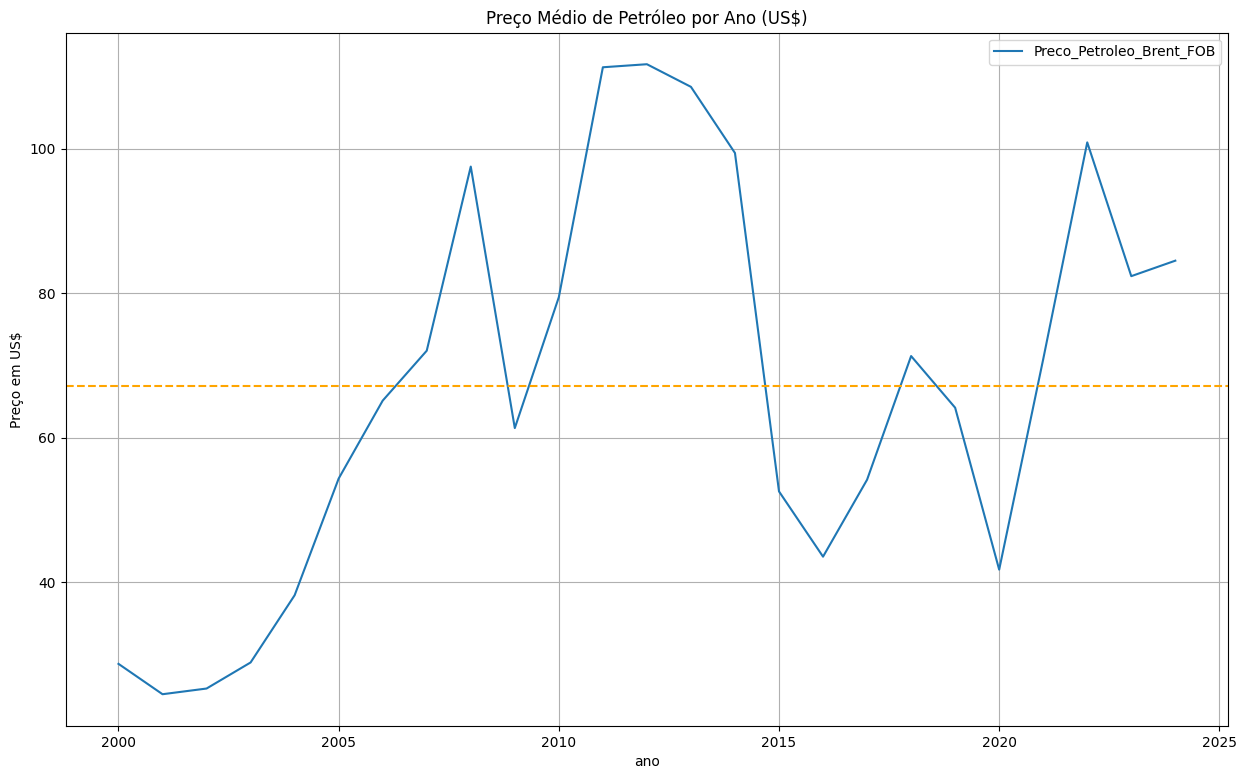

In [ ]:
plt.figure(figsize=(15,9))
sns.lineplot(groupby_ano)
plt.axhline(df_gb['Preco_Petroleo_Brent_FOB'].mean(), color='orange', linestyle='--')
plt.title('Preço Médio de Petróleo por Ano (US$)')
plt.ylabel('Preço em US$')
plt.grid()
plt.show()

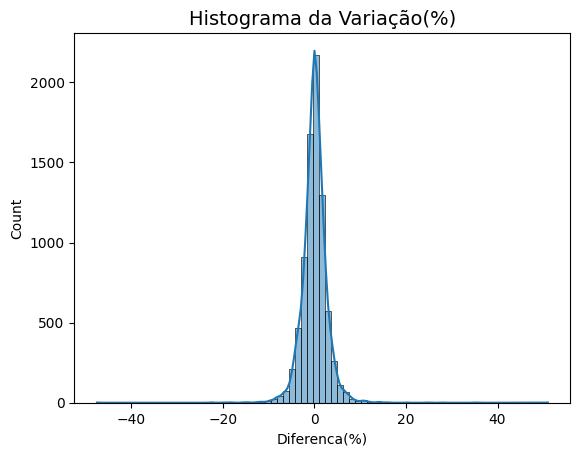

In [ ]:
sns.histplot(df_gb["Diferenca(%)"], bins = 75, kde=True)
plt.title("Histograma da Variação(%)", size = 14)
plt.show()

In [ ]:
# Média
media_variation = np.mean(df_gb["Diferenca(%)"])

# Desvio padrão
desvio_variation = np.std(df_gb["Diferenca(%)"])

print("Média da Variation:{:.2f}%".format(media_variation))
print("Desvio Padrão da Variation:{:.2f}%".format(desvio_variation))

Média da Variation:0.06%
Desvio Padrão da Variation:2.82%


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

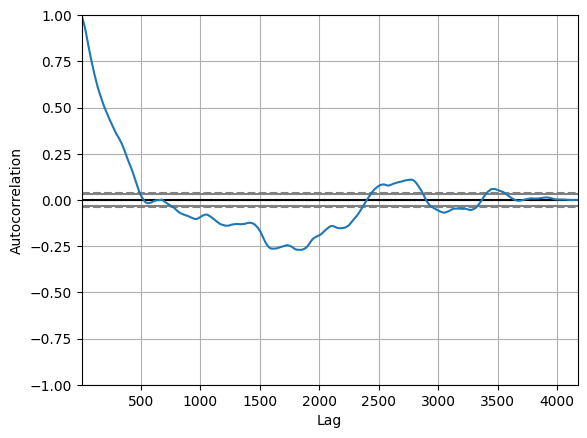

In [ ]:
autocorrelation_plot(dados['Close'])

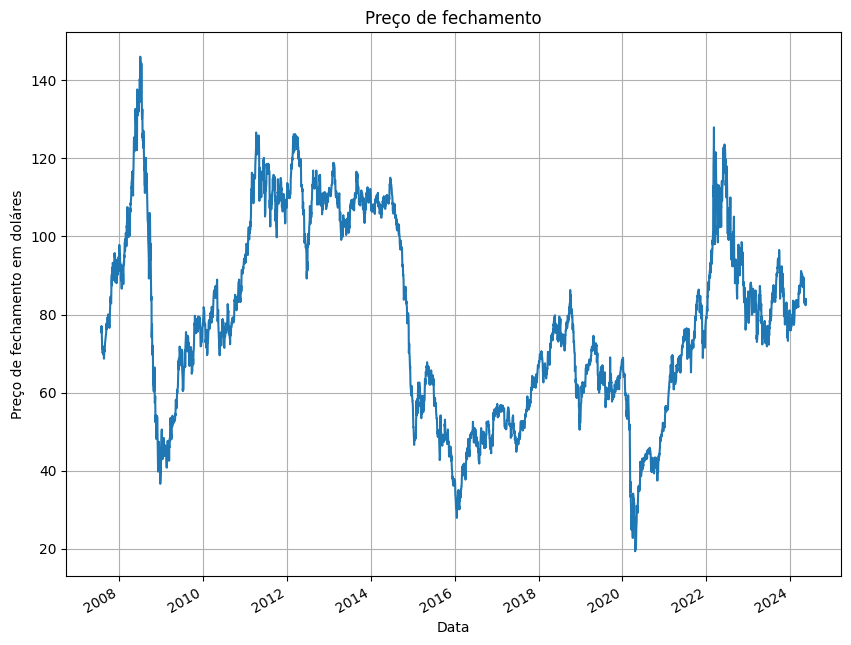

In [ ]:
dados['Close'].plot( title='Preço de fechamento', figsize=(10,8),grid=True)
plt.xlabel("Data")
plt.ylabel("Preço de fechamento em doláres")

plt.show()


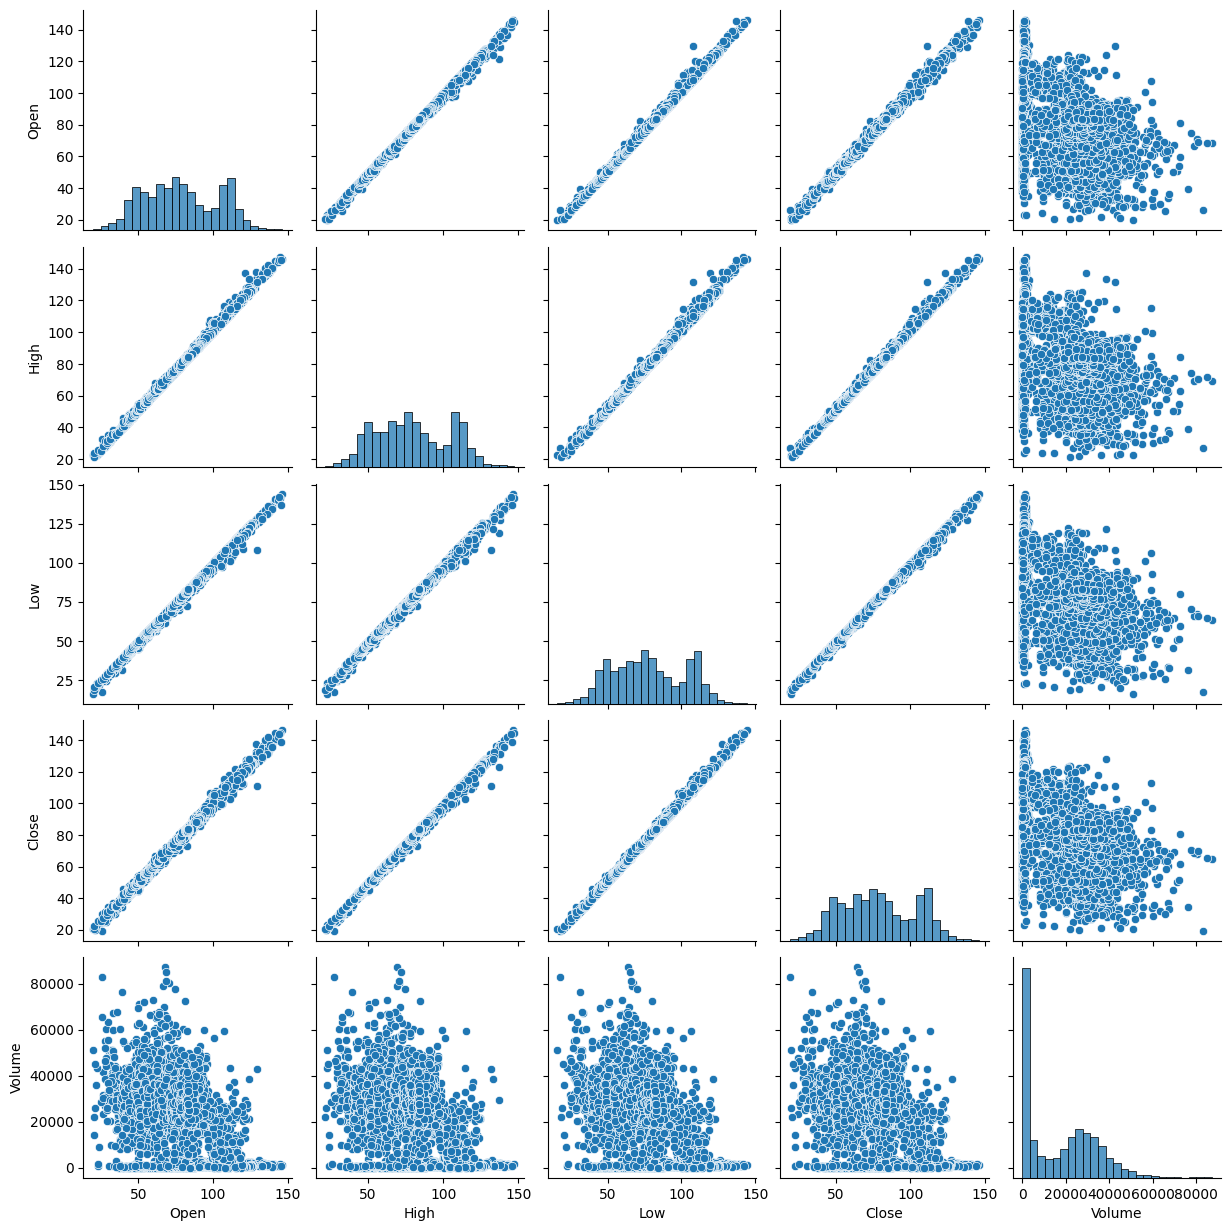

In [ ]:
sns.pairplot(dados)
plt.show()

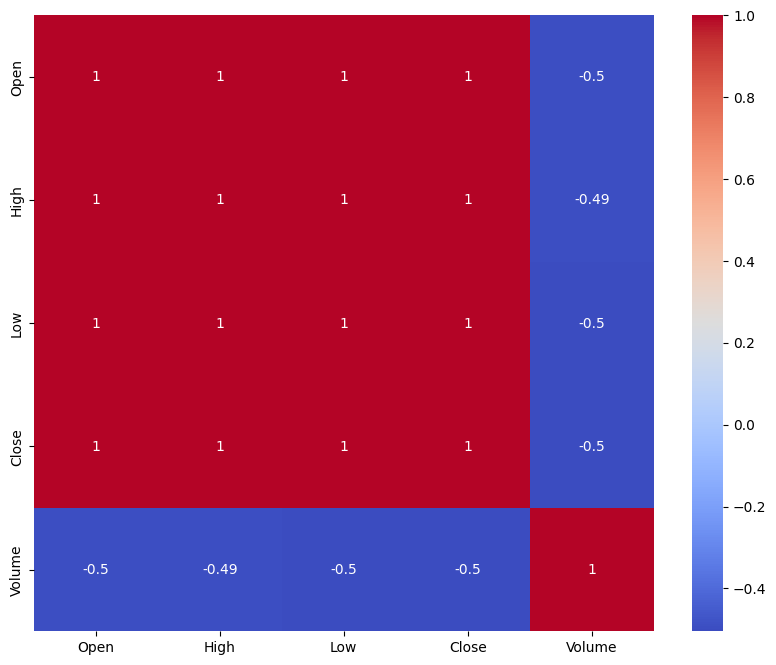

In [ ]:
plt.figure(figsize=(10, 8))

sns.heatmap(dados.corr(), annot=True, cmap='coolwarm')

plt.show()

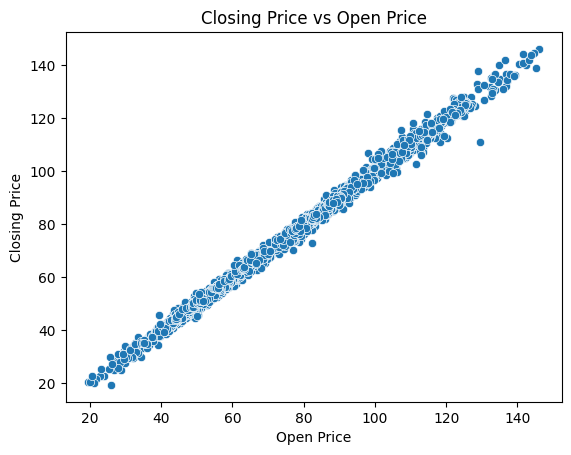

In [ ]:
sns.scatterplot(x='Open', y='Close', data=dados)

plt.title("Closing Price vs Open Price")

plt.xlabel("Open Price")

plt.ylabel("Closing Price")

plt.show()

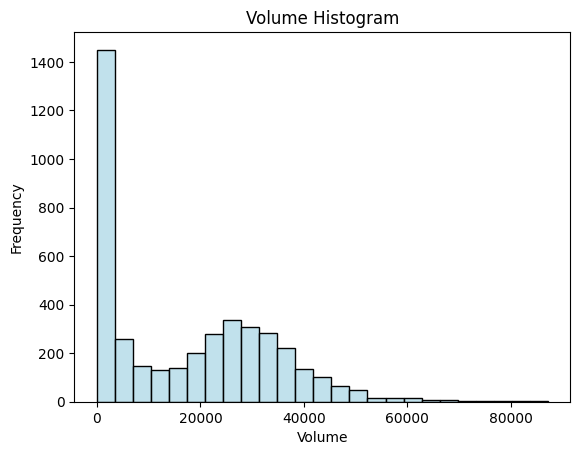

In [ ]:
# using Seaborn

sns.histplot(dados["Volume"], kde=False, color="lightblue")

plt.title("Volume Histogram")

plt.xlabel("Volume")

plt.ylabel("Frequency")

plt.show()

#  modelo Gradiente Boosting

## modelo sem update

In [ ]:
for lag in range(1, 3):  # Criou atraso de 1 dia nesse lag
    df_gb[f'Preco_lag_{lag}'] = df_gb['Preco_Petroleo_Brent_FOB'].shift(lag)

In [ ]:
df_gb.head()

,Data,Preco_Petroleo_Brent_FOB,ano,mes,Diferenca(%),Afastamento_da_media,Preco_lag_1,Preco_lag_2
0,2000-01-04,23.95,2000,1,NaN,-43.11375,NaN,NaN
1,2000-01-05,23.72,2000,1,-0.960334,-43.34375,23.95,NaN
2,2000-01-06,23.55,2000,1,-0.716695,-43.51375,23.72,23.95
3,2000-01-07,23.35,2000,1,-0.849257,-43.71375,23.55,23.72
4,2000-01-10,22.77,2000,1,-2.483940,-44.29375,23.35,23.55


In [ ]:
df_gb.isna().sum()

Data                        0
Preco_Petroleo_Brent_FOB    0
ano                         0
mes                         0
Diferenca(%)                1
Afastamento_da_media        0
Preco_lag_1                 1
Preco_lag_2                 2
dtype: int64

In [ ]:
df_gb = df_gb.dropna()

In [ ]:
df_gb.dtypes

Data                        datetime64[ns]
Preco_Petroleo_Brent_FOB           float64
ano                                  int32
mes                                  int32
Diferenca(%)                       float64
Afastamento_da_media               float64
Preco_lag_1                        float64
Preco_lag_2                        float64
dtype: object

In [ ]:
#X = df_gb.drop('y', axis=1).values
X = df_gb[['Preco_lag_1','Preco_lag_2']].values
y = df_gb['Preco_Petroleo_Brent_FOB'].values

In [ ]:
# Dividir os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=42)

In [ ]:
# Treinando o modelo
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.2, max_depth=6, random_state=42,loss='squared_error')
model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.2, max_depth=6, n_estimators=200,
                          random_state=42)

In [ ]:
# Fazendo previsões
y_pred = model.predict(X_test)

In [ ]:
# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("r2_score:", r2)

Mean Squared Error: 3.344536309695245
Mean Absolute Error: 1.2773706533014575
r2_score: 0.9914536764600678


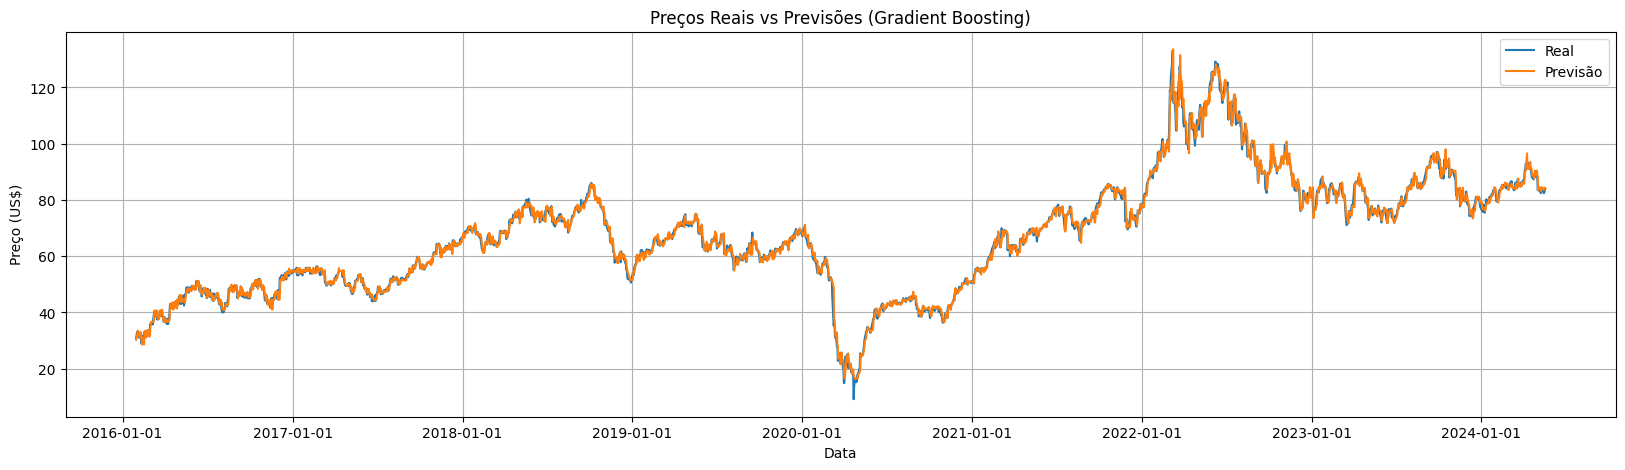

In [ ]:
# Opcional: Plotando resultados reais vs previstos. Tem que ter matplotlib instalado.


plt.figure(figsize=(20, 5))
plt.plot(df_gb['Data'].iloc[-len(y_test):], y_test, label='Real')
plt.plot(df_gb['Data'].iloc[-len(y_pred):], y_pred, label='Previsão')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#plt.gcf().autofmt_xdate()
plt.legend()
plt.xlabel('Data')
plt.ylabel('Preço (US$)')
plt.grid(True)
plt.title('Preços Reais vs Previsões (Gradient Boosting)')
plt.show()

##plotando o forecasting

In [ ]:
previsao_y = y_pred[-7:]
previsao_data = df_gb['Data'].iloc[-len(y_test):][-7:]

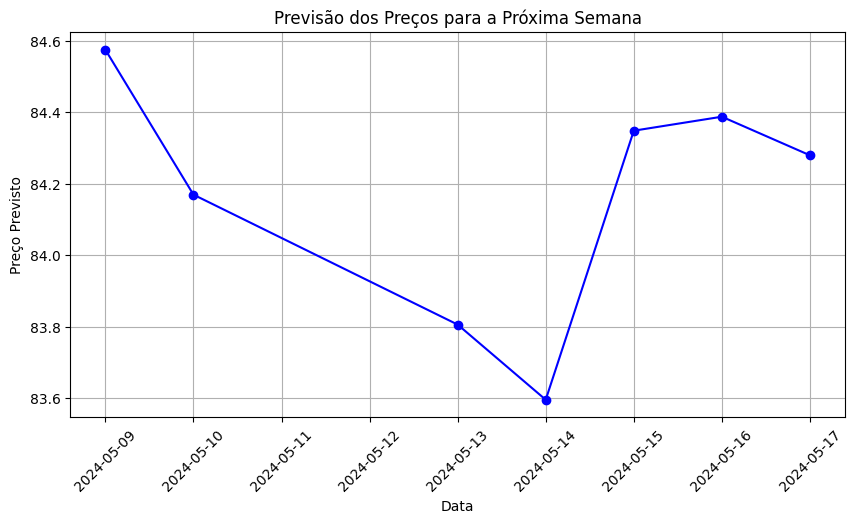

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(previsao_data[::-1], previsao_y[::-1], label='Previsão', color='blue', marker='o')
plt.title('Previsão dos Preços para a Próxima Semana')
plt.xlabel('Data')
plt.ylabel('Preço Previsto')
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [ ]:
with open("model_gb.pkl", "wb") as file:
    pickle.dump(model, file)

In [ ]:
with open("model_gb.joblib", "wb") as file:
    joblib.dump(model,file)

##tentando prever a próxima semana

In [ ]:
# Fazer previsões para a próxima semana usando os últimos dados conhecidos
num = int(input())
ultima_data = X[-1].reshape(1, -1)
pred_futuro = []
for _ in range(num):  # para cada dia da próxima semana
    pred_dia_futuro = model.predict(ultima_data)[0]
    pred_futuro.append(pred_dia_futuro)
    ultima_data = np.roll(ultima_data, -1)
    ultima_data[0, -1] = pred_dia_futuro


10


In [ ]:
# As datas correspondentes à próxima semana
prox_data = pd.date_range(df_gb['Data'].iloc[-1], periods=(num+1), freq='B')[1:]   #a frequência foi eu que coloquei, freq='B'

In [ ]:
prox_data

DatetimeIndex(['2024-05-20', '2024-05-21', '2024-05-22', '2024-05-23',
               '2024-05-24', '2024-05-27', '2024-05-28', '2024-05-29',
               '2024-05-30', '2024-05-31'],
              dtype='datetime64[ns]', freq='B')

In [ ]:
# Selecionar os dados da semana atual (últimos 7 dias do dataset)
datas_sem_atual = df_gb['Data'].iloc[-num:]
preco_sem_atual = df_gb['Preco_Petroleo_Brent_FOB'].iloc[-num:]

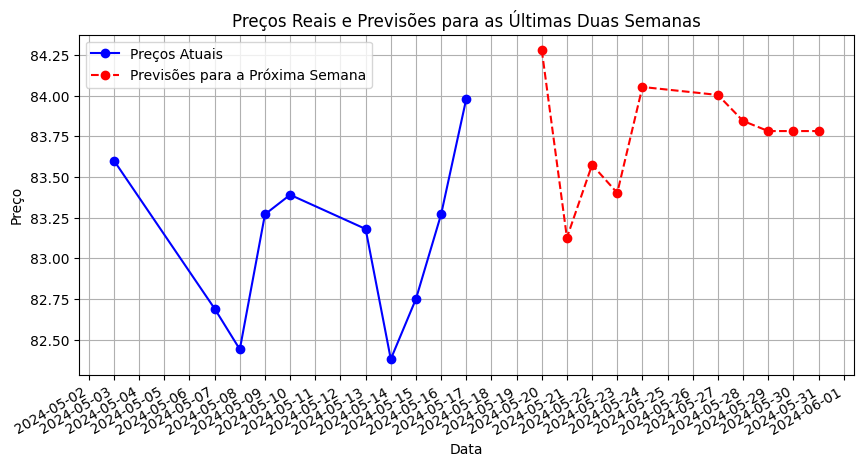

In [ ]:


# Plotar os preços reais da semana atual e as previsões para a próxima semana
plt.figure(figsize=(10, 5))
plt.plot(datas_sem_atual, preco_sem_atual, 'bo-', label='Preços Atuais')
plt.plot(prox_data, pred_futuro, 'r--o', label='Previsões para a Próxima Semana')

# Formatar o eixo x para exibir datas
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gcf().autofmt_xdate()  # Ajustar formato das datas para evitar sobreposição

plt.xlabel('Data')
plt.ylabel('Preço')
plt.title('Preços Reais e Previsões para as Últimas Duas Semanas')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
pred_futuro

[84.27954159883285,
 83.12640838428842,
 83.57448721226565,
 83.40157804835798,
 84.05263875377875,
 84.00361879462068,
 83.84388882024004,
 83.7817017118474,
 83.7817017118474,
 83.7817017118474]